### Welcome! In this lab session, you will familiarize yourself with regression analysis. We will learn how to do descriptive regression analysis in python. We will use statsmodels library. After an introductory tutorial, you will work on solving an exercise that we prepared for you.

### References:
- More information on formula syntax: https://patsy.readthedocs.io/en/latest/formulas.html
- More information on statsmodels: https://www.statsmodels.org/dev/example_formulas.html

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
data_folder = './data/'
df = pd.read_csv(data_folder + 'heart_failure_clinical_records_dataset.csv')

## Statsmodels tutorial

#### We will use a dataset with information about patients with cardiovascular diseases. Here is the breakdown of columns:

Some variables are categorical:
- 'time': duration of the follow-up period (number of days in the hospital)
- 'DEATH_EVENT': if the patient deceased during the follow-up period
- 'sex': male/female (binary, male 1, female 0)
- 'anaemia': decrease of red blood cells (boolean, yes 1)
- 'smoking': if the patient smokes or not (boolean, yes 1)
- 'diabetes': if the patient has diabetes (boolean, yes 1)
- 'high_blood_pressure': if the person has hypertension (boolean, yes 1)


... and some are continuous:
- 'age': patient's age
- 'creatinine_phosphokinase': level of CPK enzyme in the blood (mcg/L)
- 'ejection_fraction': percentage of blood leaving the heart in each contraction
- 'platelets': platelets in the blood (kiloplatelets/mL)
- 'serum_creatinine': level of serum creatinine in the blood (mg/dL)
- 'serum_sodium': level of serum sodium in the blood (mEq/L)

In [4]:
df.sample(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
15,82.0,1,379,0,50,0,47000.00,1.30,136,1,0,13,1
254,53.0,1,446,0,60,1,263358.03,1.00,139,1,0,215,0
33,50.0,1,159,1,30,0,302000.00,1.20,138,0,0,29,0
281,70.0,0,582,0,40,0,51000.00,2.70,136,1,1,250,0
138,62.0,0,281,1,35,0,221000.00,1.00,136,0,0,108,0
56,70.0,1,75,0,35,0,223000.00,2.70,138,1,1,54,0
250,50.0,0,2522,0,30,1,404000.00,0.50,139,0,0,214,0
80,70.0,0,69,0,40,0,293000.00,1.70,136,0,0,75,0
69,65.0,0,113,1,25,0,497000.00,1.83,135,1,0,67,1
135,75.0,0,582,0,40,0,263358.03,1.18,137,1,0,107,0


In [5]:
#299 patients

len(df)

299

## Part 1 Linear regression: Modelling time spent at the hospital

- We will perform a regression analysis to model the number of days spent at the hospital, among the population of patients.

### Creating our model

- To get started with our model, we need two components,

   1. The equation describing the model
   2. The data
   
- Equations are specified using patsy formula syntax. Important operators are:
        1. ~ : Separates the left-hand side and right-hand side of a formula.
        2. + : Creates a union of terms that are included in the model.
        3. : : Interaction term.
        3. * : a * b is short-hand for a + b + a:b, and is useful for the common case of wanting to include all interactions between a set of variables.
- Intercepts are added by default.
- Categorical variables can be included directly by adding a term C(a). More on that soon!
- For (2), we can conveniently use pandas dataframe

- Let's start with an example from our dataset. We are interested in two predictors: diabetes and high blood pressure. These are the two predictors that we want to use to fit the outcome, the number of days spent at the hospital, using a linear regression.

- An model that achieves this is formulated as:
        time ~ C(diabetes) + C(high_blood_pressure)

### First, we create a model using smf.ols()
- OLS stands for ordinary least squares linear regression
- The two components: the formula and the data are stated explicitly.
- The terms in the formula are columns in pandas dataframe. Easy!

In [6]:
mod = smf.ols(formula='time ~ C(diabetes) + C(high_blood_pressure)', data=df)

### Then we fit the model to find the optimal coefficients.

In [7]:
res = mod.fit()

### And then, we print the summary output provided by the library.

In [8]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.097
Date:                Wed, 14 Oct 2020   Prob (F-statistic):            0.00254
Time:                        17:02:56   Log-Likelihood:                -1718.9
No. Observations:                 299   AIC:                             3444.
Df Residuals:                     296   BIC:                             3455.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### Many useful information are provided by default.

- The dependent variable : time (number of days at the hospital)
- Method: The type of model that was fitted (OLS)
- Nb observations: The number of datapoints (299 patients)
- R2: The fraction of explained variance
- A list of predictors
- For each predictor: coefficient, standard error of the coefficients, p-value, 95% confidence intervals. We can see that only high blood pressure is a significant predictor (p = 0.001), while diabetes is not (0.584).
- Warnings if there are numerical issues (hopefully not!)

### Now, we can interpret the model that we just fitted.

- Notice how C(diabetes)[T.1] is created based on the original diabetes feature. This means that the dummy variable is encoded such that the associated coefficient tells us about the value among the diabetes = yes subpopulation.
- We interpret the model in the following way:
- days at hospital = 139 + 4.9 * diabetes - 31.8 * high blood pressure
        1. People who don't have diabetes and who don't have high blood pressure stay at the hospital on average for 139 days
        2. People who have diabetes, but don't have blood pressure stay for 139 + 4.9 days ~ 144 days
        3. People who don't have diabetes, but have blood pressure stay for 139 - 31 days ~ 108 days
        4. People who have diabetes and blood pressure stay for 139 + 4.9 - 31.8 ~ 112 days

- We calculate the means explicitly to make sure they are the same as what we just calculated with regression!

In [9]:
print(df.loc[(df['diabetes'] == 0) & (df["high_blood_pressure"] == 0)]['time'].mean())
print(df.loc[(df['diabetes'] == 1) & (df["high_blood_pressure"] == 0)]['time'].mean())
print(df.loc[(df['diabetes'] == 0) & (df["high_blood_pressure"] == 1)]['time'].mean())
print(df.loc[(df['diabetes'] == 1) & (df["high_blood_pressure"] == 1)]['time'].mean())

139.0
144.8170731707317
108.25806451612904
111.46511627906976


- Isn't it strange that high blood pressure has a negative coefficient? It seems like the patients who have high blood pressure stay at the hospital for shorter number of days, even though one would expect the opposite. Lets' get to that!

## Part 2 Linear regression with interaction terms: Modelling time spent at the hospital V2

- One reason why serious conditions can be associated with lower time spent at the hospital is because of a third confounding factor: death 💀. Patients who have a serious condition might spend less time at the hospital because of that.

- Let's get a better sense of what is happening by modeling the time spent at the hospital with death as a predictor.

- This time we will add interaction features.

In [10]:
# we use a*b to add terms: a, b, a:b, and intercept

mod = smf.ols(formula='time ~ C(high_blood_pressure)*C(DEATH_EVENT)',
              data=df)

# This is how we can alternatively choose the reference categories
#mod = smf.ols(formula='time ~ C(high_blood_pressure, Treatment(reference=1))*C(DEATH_EVENT, Treatment(reference=1))',
#              data=df)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     42.51
Date:                Wed, 14 Oct 2020   Prob (F-statistic):           7.33e-23
Time:                        17:05:25   Log-Likelihood:                -1671.2
No. Observations:                 299   AIC:                             3350.
Df Residuals:                     295   BIC:                             3365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Interpretation:

- This model lets us see that death is associated with a lower number of days spent at the hospital.
- Notice how R2 is much larger compared to the previous model: more variance in the data is explained.

## Part 3 Logistic regression: Modelling the binary death outcome

- Finally, let's model the binary outcome of death, based on all patients' features.
- We will exclude time spent at the hospital, since we saw how it is strongly correlated with death.

### First, we will do standardization of continuous predictors. This will let us interpret the predictors that are of vastly different scales (from percents to thousands).

In [14]:
#how we standardize the countinuous variables

df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
df['creatinine_phosphokinase'] = (df['creatinine_phosphokinase'] - df['creatinine_phosphokinase'].mean())/df['creatinine_phosphokinase'].std()
df['ejection_fraction'] = (df['ejection_fraction'] - df['ejection_fraction'].mean())/df['ejection_fraction'].std()
df['platelets'] = (df['platelets'] - df['platelets'].mean())/df['platelets'].std()
df['serum_creatinine'] = (df['serum_creatinine'] - df['serum_creatinine'].mean())/df['serum_creatinine'].std()
df['serum_sodium'] = (df['serum_sodium'] - df['serum_sodium'].mean())/df['serum_sodium'].std()

df # now standardized

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,1.190949,0,0.000165,0,-1.527998,1,1.678834e-02,0.489237,-1.501519,1,0,4,1
1,-0.490457,0,7.502063,0,-0.007065,0,7.523048e-09,-0.284076,-0.141739,1,0,6,1
2,0.350246,0,-0.449186,0,-1.527998,0,-1.036336e+00,-0.090748,-1.728149,1,1,7,1
3,-0.910808,1,-0.485257,0,-1.527998,0,-5.455595e-01,0.489237,0.084892,1,0,7,1
4,0.350246,1,-0.434757,1,-1.527998,0,6.507077e-01,1.262550,-4.674340,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098035,0,-0.536789,1,-0.007065,1,-1.107907e+00,-0.284076,1.444672,1,1,270,0
295,-0.490457,0,1.276075,0,-0.007065,0,6.791087e-02,-0.187412,0.538152,0,0,271,0
296,-1.331160,0,1.523425,1,1.851853,0,4.893878e+00,-0.574068,0.311522,0,0,278,0
297,-1.331160,0,1.887234,0,-0.007065,0,-1.261275e+00,0.005916,0.764782,1,1,280,0


### Instead of linear, we will now use logistic regression to model the binary outcome.

In [22]:
#logit is loigistic regression. The other parameters are the same as before

mod = smf.logit(formula='DEATH_EVENT ~  age + creatinine_phosphokinase + ejection_fraction + \
                        platelets + serum_creatinine + serum_sodium + \
                        C(diabetes) + C(high_blood_pressure) +\
                        C(sex) + C(anaemia) + C(smoking) + C(high_blood_pressure)', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.492108
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  299
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                           11
Date:                Wed, 14 Oct 2020   Pseudo R-squ.:                  0.2160
Time:                        17:25:17   Log-Likelihood:                -147.14
converged:                       True   LL-Null:                       -187.67
Covariance Type:            nonrobust   LLR p-value:                 9.169e-13
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.1633      0.362     -3.214      0.001   

#### Looks good! We have a reasonably high R2 (0.216). In addition to reading the coefficients from the summary table, let's access them programmatically from the res object.

In [23]:
#feature names
variables = res.params.index

#Quantifying uncertainty!

#coefficients
coefficients = res.params.values

#p-values
p_values = res.pvalues

#standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

,0,1
Intercept,-1.872683,-0.453819
C(diabetes)[T.1],-0.431428,0.734243
C(high_blood_pressure)[T.1],-0.180976,1.018851
C(sex)[T.1],-1.086628,0.288599
C(anaemia)[T.1],-0.171894,1.007753
C(smoking)[T.1],-0.547629,0.818807
age,0.356256,0.968609
creatinine_phosphokinase,0.010320,0.553497
ejection_fraction,-1.177018,-0.487482
platelets,-0.379319,0.240561


### Now we can visualize the effect of all the predictors. Let's first sort them by the coefficients.

In [25]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

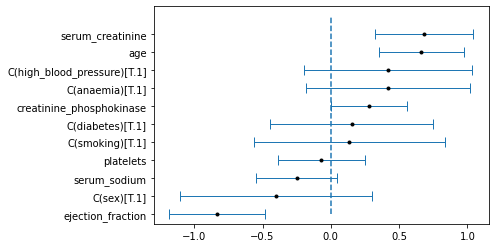

In [26]:
#fancy plotting

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

### Interpretation:
- Serum creatinine level in the blood and age are significant positive predictors of death
- High ejection fraction (a healthy heart) is a sigificant negative predictor of death
- Since all predictors are standardized, we can interpret in the following way:
        - When all other predictors take mean values, an increase of age by 1 standard deviation, leads on average to an increase by 0.66 of log odds of death (40% probability)
        - When all other predictors take mean values, increase of ejection fraction by 1 standard deviation, leads on average to a  decrease by 0.83 of log odds of death (45% probability)
- Why log odds? remember that that's what logistic regression models.